# Predicting Forest Type with Spectral Mapping Data

This project aims to build a classification model that predicts the type of forest based on spectral data.

The data set is provided by the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+type+mapping#) and is analyzed in the paper: Johnson, B., Tateishi, R., Xie, Z., 2012. Using geographically-weighted variables for image classification. Remote Sensing Letters, 3 (6), 491-499.

According to the paper:

>The study area for this article was a forested area in Ibaraki Prefecture, Japan ([centered at] 36◦57′N, 140◦38′E), approximately 13 km×12 km. The landscape consists mainly of Cryptomeria japonica (Sugi, or Japanese Cedar) planted forest, Chamaecyparisobtusa (Hinoki, or Japanese Cypress) planted forest and mixed deciduous broad leaf natural forest, with a small amount of other land use/land cover types scattered throughout the image (agriculture, roads, buildings and so on). Each of the three forest types has different economic uses and environmental conservation values, so accurate mapping of their locations is important for economic and ecological studies.

>Orthorectified ASTER imagery was acquired for three dates in different seasons (26 September 2010, 19 March 2011 and 8 May 2011) to provide adequate spectral discrimination between coniferous and deciduous tree species. Although the acquired images had been orthorectified, pixels in the September image were still offset by about 15–30 m from corresponding pixels in the other two images. To prevent classification errors caused by misaligned pixels, we further georectified the 26 September image using ground control points until the misalignment was less than 15 m (one pixel).

>Since we were mainly interested in reflected spectral information rather than thermal information, only the green (0.52–0.60μm), red (0.63–0.69μm) and near-infrared (NIR) (0.76–0.86μm) bands from each image were used for analysis (total of ninebands, 15 m spatial resolution).

## Data Dictionary

Target Variable Classes:

- 's' ('Sugi' forest)
- 'h' ('Hinoki' forest)
- 'd' ('Mixed deciduous' forest)
- 'o' ('Other' non-forest land)

Attributes:

- **b1 - b9**: ASTER image bands containing spectral information in the green, red, and near-infrared wavelengths for three dates (Sept. 26, 2010; March 19, 2011; and May 08, 2011)
- **pred_minus_obs_S_b1 - pred_minus_obs_S_b9**: Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 's' class (b1-b9)
- **pred_minus_obs_H_b1 - pred_minus_obs_H_b9**: Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 'h' class (b1-b9)

## Library Imports

In [98]:
import io
import glob
import requests
import zipfile

import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing, metrics, and cross validation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Import classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

## Exploratory Data Analysis and Data Visualizations

In [99]:
# Retrieve data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00333/ForestTypes.zip'

response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    zf.printdir()
    zf.extractall('./Data/')

File Name                                             Modified             Size
training.csv                                   2015-05-26 14:47:22        28513
testing.csv                                    2015-05-26 14:46:26        46452


In [100]:
# Import and concatenate
files = glob.glob('./Data/*.csv')
dfs = []

for f in files:
    print(f)
    dfs.append(pd.read_csv(f))

df = pd.concat(dfs, ignore_index=True)
df.tail()

./Data/training.csv
./Data/testing.csv


,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,pred_minus_obs_H_b1,pred_minus_obs_H_b2,pred_minus_obs_H_b3,pred_minus_obs_H_b4,pred_minus_obs_H_b5,pred_minus_obs_H_b6,pred_minus_obs_H_b7,pred_minus_obs_H_b8,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
518,o,55,56,72,91,79,113,86,35,68,62.20,-3.86,26.38,12.12,-54.09,-53.39,-5.91,-5.65,-12.86,-23.08,-0.08,-3.46,-27.52,-1.04,-4.73,-22.85,-1.49,-4.10
519,d,69,49,76,91,52,91,92,25,57,34.95,-1.55,15.12,5.44,-27.45,-32.64,-21.49,4.32,-2.36,-11.47,-0.40,-3.74,-16.90,-0.78,-4.15,-11.13,-1.48,-3.55
520,s,49,26,48,107,59,104,62,22,53,69.86,27.76,52.66,-5.12,-33.88,-44.00,19.16,7.36,2.32,-23.48,1.44,-1.59,-26.98,-1.36,-4.81,-24.50,-2.53,-4.97
521,s,55,26,52,92,55,98,65,23,56,63.64,27.89,49.05,7.68,-29.90,-37.98,15.52,6.23,-0.77,-23.74,1.27,-1.30,-25.53,-1.21,-4.70,-24.39,-2.21,-4.72
522,h,71,28,51,96,46,88,92,25,58,34.77,19.40,40.01,-0.98,-21.56,-29.89,-20.38,4.30,-3.24,-13.96,-0.44,-3.84,-15.45,-0.71,-3.94,-12.74,-1.36,-3.63


In [101]:
df.shape

(523, 28)

In [102]:
# Shorten column names
cols = ['class'] + [s + str(i) for s in ['b', 'p-oHb', 'p-oSb'] for i in range(1, 10)]
df.columns = cols

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 28 columns):
class     523 non-null object
b1        523 non-null int64
b2        523 non-null int64
b3        523 non-null int64
b4        523 non-null int64
b5        523 non-null int64
b6        523 non-null int64
b7        523 non-null int64
b8        523 non-null int64
b9        523 non-null int64
p-oHb1    523 non-null float64
p-oHb2    523 non-null float64
p-oHb3    523 non-null float64
p-oHb4    523 non-null float64
p-oHb5    523 non-null float64
p-oHb6    523 non-null float64
p-oHb7    523 non-null float64
p-oHb8    523 non-null float64
p-oHb9    523 non-null float64
p-oSb1    523 non-null float64
p-oSb2    523 non-null float64
p-oSb3    523 non-null float64
p-oSb4    523 non-null float64
p-oSb5    523 non-null float64
p-oSb6    523 non-null float64
p-oSb7    523 non-null float64
p-oSb8    523 non-null float64
p-oSb9    523 non-null float64
dtypes: float64(18), int64(9), object(1)
memor

In [104]:
df.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,p-oHb1,p-oHb2,p-oHb3,p-oHb4,p-oHb5,p-oHb6,p-oHb7,p-oHb8,p-oHb9,p-oSb1,p-oSb2,p-oSb3,p-oSb4,p-oSb5,p-oSb6,p-oSb7,p-oSb8,p-oSb9
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,59.887189,39.380497,62.304015,98.156788,58.338432,99.747610,87.657744,27.873805,59.726577,53.906004,11.567782,34.060000,-0.276138,-33.011644,-39.494895,-10.995258,1.843002,-4.194283,-20.017304,-1.056195,-4.368203,-21.411568,-0.977514,-4.619809,-18.937228,-1.652199,-4.201377
std,12.345004,15.930120,15.937658,12.881210,11.336637,10.151598,16.398751,8.076700,9.291151,12.754964,16.311623,16.746541,13.222536,11.277147,9.951563,16.476999,8.159354,9.306667,3.806830,1.375642,2.053012,4.901451,0.495208,1.352096,4.147427,1.371180,1.518350
min,31.000000,23.000000,47.000000,54.000000,43.000000,83.000000,42.000000,19.000000,45.000000,4.950000,-112.600000,-106.120000,-77.010000,-74.560000,-77.170000,-62.740000,-54.740000,-58.280000,-32.950000,-8.800000,-11.210000,-40.370000,-3.270000,-8.730000,-34.140000,-8.870000,-10.830000
25%,51.500000,28.000000,52.000000,90.000000,50.000000,93.000000,76.000000,24.000000,54.500000,45.565000,3.190000,28.050000,-8.635000,-38.470000,-43.725000,-21.845000,2.535000,-5.025000,-22.505000,-1.795000,-5.625000,-24.175000,-1.210000,-5.525000,-21.820000,-2.370000,-4.940000
50%,58.000000,32.000000,56.000000,96.000000,55.000000,97.000000,88.000000,25.000000,57.000000,55.410000,18.860000,39.830000,1.760000,-28.950000,-36.520000,-11.540000,4.300000,-1.880000,-19.990000,-1.030000,-4.460000,-20.830000,-0.980000,-4.640000,-19.050000,-1.580000,-4.130000
75%,67.000000,48.000000,67.000000,107.000000,64.000000,104.000000,99.000000,27.000000,60.000000,62.340000,22.675000,44.620000,8.870000,-24.660000,-32.415000,0.400000,5.680000,0.915000,-18.080000,-0.300000,-2.840000,-18.735000,-0.730000,-3.810000,-16.610000,-0.915000,-3.245000
max,107.000000,160.000000,196.000000,172.000000,100.000000,138.000000,139.000000,84.000000,114.000000,86.080000,29.900000,57.550000,40.820000,-18.400000,-23.550000,34.660000,10.830000,9.580000,5.130000,12.460000,7.370000,1.880000,3.440000,3.940000,3.670000,8.840000,7.790000


In [105]:
df.describe(include='object')

,class
count,523
unique,4
top,s
freq,195


In [106]:
df['class'].value_counts()

s     195
d     159
h      86
o      83
Name: class, dtype: int64

In [107]:
# Split target and features
y = df['class']
X = df.drop('class', axis=1)

In [108]:
# Encode classes as numeric categories
lb = LabelEncoder()
y = lb.fit_transform(y)
y = pd.Series(y, name='class')

y.head()

0    0
1    1
2    3
3    3
4    0
Name: class, dtype: int64

<Figure size 432x288 with 0 Axes>

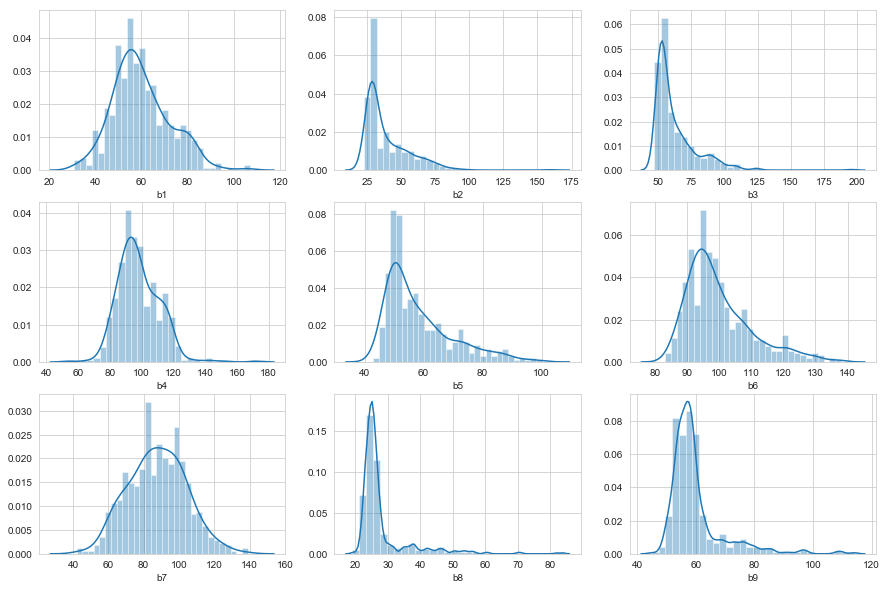

In [109]:
# View histograms for b1-9
b_cols = ['b' + str(i) for i in range(1, 10)]

plt.figure()
plt.subplots(3, 3, figsize=(15, 10))

for i, b in enumerate(b_cols, 1):
    plt.subplot(3, 3, i)
    sns.distplot(X[b], bins=30)

<Figure size 432x288 with 0 Axes>

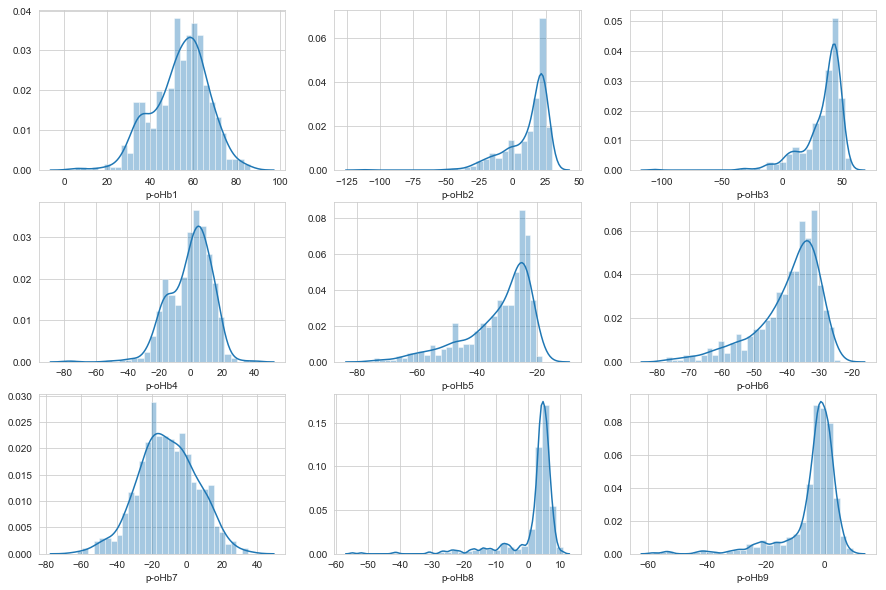

In [110]:
# View histograms for p-oHb1-9
h_cols = ['p-oHb' + str(i) for i in range(1, 10)]

plt.figure()
plt.subplots(3, 3, figsize=(15, 10))

for i, h in enumerate(h_cols, 1):
    plt.subplot(3, 3, i)
    sns.distplot(X[h], bins=30)

<Figure size 432x288 with 0 Axes>

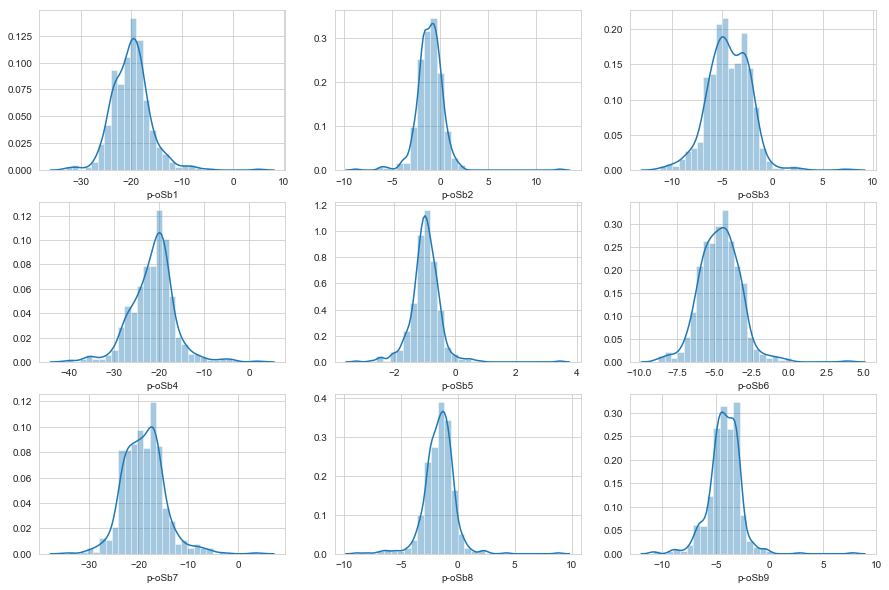

In [111]:
# View histograms for p-oSb1-9
s_cols = ['p-oSb' + str(i) for i in range(1, 10)]

plt.figure()
plt.subplots(3, 3, figsize=(15, 10))

for i, s in enumerate(s_cols, 1):
    plt.subplot(3, 3, i)
    sns.distplot(X[s], bins=30)

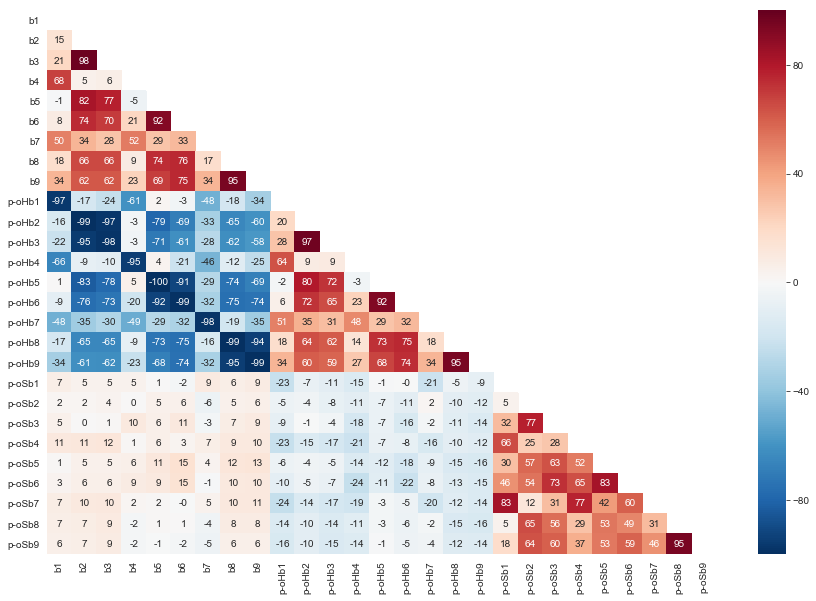

In [112]:
# Create correlation matrix
correlations = X.corr()

mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.heatmap(correlations*100, annot=True, fmt='.0f', mask=mask, cmap='RdBu_r')

The matrix shows strong correlations within each group, almost no correlation between the predicted minus observed "S" class and the other groups, but some strong negative correlations between the image bands (b1-9) and the predicted minus observed "H" class.

In [113]:
# Reshape spectral (b1-9) readings by date to create RGB image approximation

# Helper function to process sets of bands
def get_im_shape(df, cols):
    '''
    Takes columns and a DataFrame, returns an array in image-friendly shape
    :param df: DataFrame object
    :param cols: sequence of 3 columns to select from df
    :return: reshaped np.array
    '''
    channels = np.array(df[cols])
    
    # Remove last item so length is 522 and has factors (29, 18)
    channels = channels[:-1]
    # print(channels.shape)  # (522, 3)
    channels = channels.reshape(29, 18, 3)

    return channels

<Figure size 432x288 with 0 Axes>

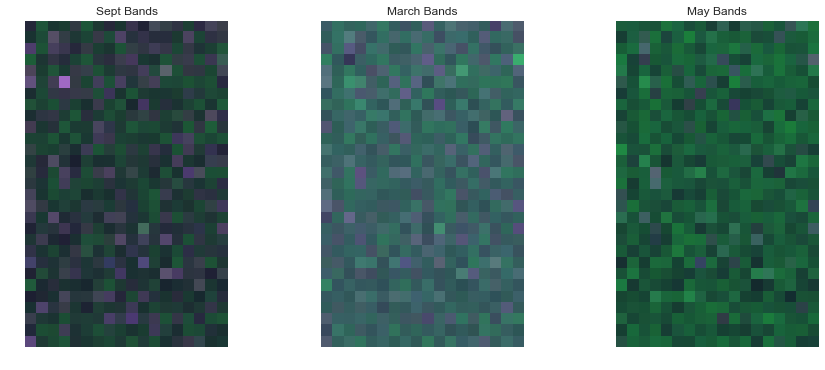

In [118]:
# Create RGB approximation images for b1-9 bands

# Original order - very red-toned image, hard to distinguish patterns
# green -> R, red -> G, NIR -> B
# b_channel_info = [('Sept Bands', ['b1', 'b2', 'b3']),
#                   ('March Bands', ['b4', 'b5', 'b6']),
#                   ('May Bands', ['b7', 'b8', 'b9'])]

# NIR -> R, red -> R, green -> B - very purple-toned image, also hard to read
# b_channel_info = [('Sept Bands', ['b3', 'b2', 'b1']),
#                   ('March Bands', ['b6', 'b5', 'b4']),
#                   ('May Bands', ['b9', 'b8', 'b7'])]

# red -> R, green -> G, NIR -> B - green-toned image, best clarity
b_channel_info = [('Sept Bands', ['b2', 'b1', 'b3']),
                  ('March Bands', ['b5', 'b4', 'b6']),
                  ('May Bands', ['b8', 'b7', 'b9'])]

# Create images
plt.figure()
plt.subplots(1, 3, figsize=(15, 6))

for i, item in enumerate(b_channel_info, 1):
    channels = get_im_shape(X, item[1])
    plt.subplot(1, 3, i)
    plt.title(item[0])
    plt.axis('off')
    plt.imshow(channels)

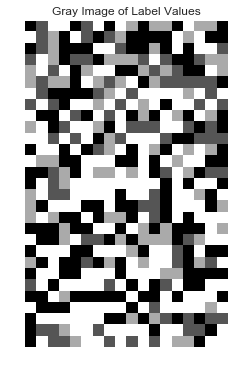

In [115]:
# Create grayscale image of labels

# Convert labels (0-3) to 0-255 scale
y_grays = y.map(lambda x: x / (y.max() - y.min()) * 255)

# Remove last item so length is 522 and has factors (29, 18) and reshape
y_grays = np.array(y_grays)[:-1].reshape(29, 18)

# Create the image
plt.figure(figsize=(5, 6))
plt.title('Gray Image of Label Values')
plt.axis('off')
plt.imshow(y_grays, cmap='gray')

The images on their own don't convey much information, but comparing the different dates to each other as well as to the label image reveals some similar patterns. The spectral information (near-infrared, red, and green) happened to have values within the range 0-255, but are not actually RGB values and were used only as a proxy for RGB channels to in order to visualize the pattern.

## Model Training and Algorithm Selection

In [119]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(366, 27) (157, 27) (366,) (157,)


In [120]:
# Set up simple data processing pipelines for each model
pipelines = {}

pipelines['logreg'] = Pipeline([('scaler', StandardScaler()),
                                ('logreg', LogisticRegression(multi_class='multinomial',
                                                              solver='newton-cg',
                                                              random_state=42))])

pipelines['sgd'] = Pipeline([('scaler', StandardScaler()),
                             ('sgd', SGDClassifier(max_iter=20,
                                                   random_state=42))])

pipelines['rf'] = Pipeline([('scaler', StandardScaler()),
                            ('rf', RandomForestClassifier(random_state=42))])

In [121]:
# Setup hyperparameter grids for each model: step_name__parameter_name
logreg_hp = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

sgd_hp = {'sgd__alpha': [0.0001, 0.00001],
          'sgd__penalty': ['l2', 'elasticnet']}

rf_hp = {'rf__n_estimators': [100, 200],
         'rf__max_features': ['auto', 'sqrt'],
         'rf__min_samples_leaf': [1, 3, 5, 10]}

hyperparameters = {
    'logreg': logreg_hp,
    'sgd': sgd_hp,
    'rf': rf_hp
}

In [122]:
# Run GridSearch cross validation to tune model hyperparameters
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

logreg has been fitted.
sgd has been fitted.
rf has been fitted.


In [123]:
# Compare model performance
for name, model in fitted_models.items():
    print('Model: {}'.format(name))
    print('CV best score (accuracy): {0:.1f}'.format(model.best_score_*100))
    print('Best hyperparameters: {}'.format(model.best_params_))
    pred = model.predict(X_test)
    print('Test set score (accuracy): {0:.1f}'.format(model.score(X_test, y_test)*100))
    print('--------------------')
    print('Confusion Matrix')
    print(confusion_matrix(y_test, pred))
    print('--------------------')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('\n')

Model: logreg
CV best score (accuracy): 89.9
Best hyperparameters: {'logreg__C': 1}
Test set score (accuracy): 89.2
--------------------
Confusion Matrix
[[45  0  1  2]
 [ 0 22  0  4]
 [ 5  0 19  1]
 [ 1  3  0 54]]
--------------------
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        48
           1       0.88      0.85      0.86        26
           2       0.95      0.76      0.84        25
           3       0.89      0.93      0.91        58

   micro avg       0.89      0.89      0.89       157
   macro avg       0.90      0.87      0.88       157
weighted avg       0.89      0.89      0.89       157



Model: sgd
CV best score (accuracy): 86.6
Best hyperparameters: {'sgd__alpha': 0.0001, 'sgd__penalty': 'elasticnet'}
Test set score (accuracy): 89.8
--------------------
Confusion Matrix
[[43  0  1  4]
 [ 0 22  0  4]
 [ 2  0 22  1]
 [ 2  2  0 54]]
--------------------
Classification Report
              

## Key Takeaways

All models returned similar values for their cross-validated accuracy scores, which were in the high-80% range. The Stochastic Gradient Descent classifier was slightly better than the others against the test set, returning an accuracy of  89.8%, but the differences could likely go away with more iterations of tuning.

Given more training time, the 'winning' model could be further improved with a larger hyperparameter grid, both to test a wider range of values for `alpha` as well as to test other parameters. For example, since `elasticnet` bested `l2` as the penalty, another iteration could run various options for the `l1_ratio`.

One hurdle for this project in general was the small size of the dataset. Collecting more data is not always feasible, but overall model performance would likely improve if there were more observations for each forest type, or with spectral data for additional dates for the existing observations.